Loading file: P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
Loading file: P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
Loading file: P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
Loading file: P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
Loading segmentation file: P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii
Image shape (should be [H, W, D, 4]): (240, 240, 15

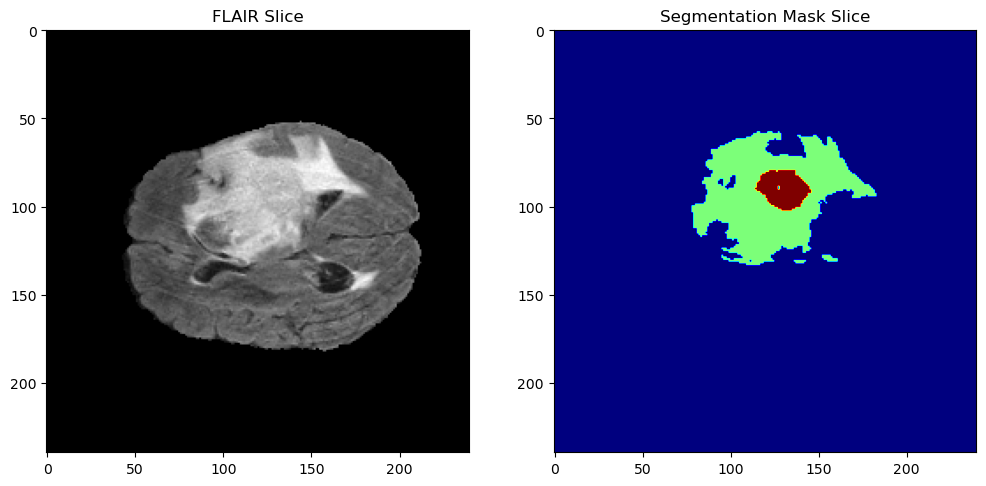

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
from skimage.transform import resize


# Base paths for training and validation data
train_data_path = r"P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
val_data_path = r"P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"

def load_patient_data(patient_dir):
    """
    Load all modalities (flair, t1, t1ce, t2) and the segmentation mask (seg) for a given patient.
    Assumes file naming convention: <patient_folder>_<modality>.nii
    """
    # Define modalities (note: seg is handled separately)
    modalities = ['flair', 't1', 't1ce', 't2']
    images = []
    patient_id = os.path.basename(patient_dir)  # e.g., "BraTS_Training_001"
    
    for modality in modalities:
        # Construct file name for the modality
        file_name = f"{patient_id}_{modality}.nii"
        file_path = os.path.join(patient_dir, file_name)
        print("Loading file:", file_path)  # Debug print to verify the path
        img = nib.load(file_path).get_fdata()
        images.append(img)
    
    # Stack modalities along a new channel axis (resulting shape: [H, W, D, 4])
    multi_modal_image = np.stack(images, axis=-1)
    
    # Load the segmentation mask
    seg_file = f"{patient_id}_seg.nii"
    seg_path = os.path.join(patient_dir, seg_file)
    print("Loading segmentation file:", seg_path)
    seg = nib.load(seg_path).get_fdata()
    
    return multi_modal_image, seg

# Example usage for a training patient
patient_folder = os.path.join(train_data_path, "BraTS20_Training_001")
try:
    image_data, seg_mask = load_patient_data(patient_folder)
    print("Image shape (should be [H, W, D, 4]):", image_data.shape)
    print("Segmentation mask shape:", seg_mask.shape)
    
    # Visualize a middle slice from one modality (for example, FLAIR channel, index 0)
    slice_idx = image_data.shape[2] // 2
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, slice_idx, 0], cmap='gray')
    plt.title("FLAIR Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(seg_mask[:, :, slice_idx], cmap='jet')
    plt.title("Segmentation Mask Slice")
    plt.show()
except Exception as e:
    print("Error loading patient data:", e)


In [2]:
# -----------------------------
# 2. Data Preprocessing
# -----------------------------
# For deep learning, it's important to normalize the images.
def normalize(image):
    """
    Normalize image to range [0, 1]
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Normalize the multi-modal image and segmentation mask remains unchanged (as it is categorical)
image_data_norm = normalize(image_data)

In [3]:


def build_3d_unet(input_shape):
    """
    Build a 3D U-Net model with input shape (height, width, depth, channels)
    Expected output shape: (None, height, width, depth, num_classes)
    """
    inputs = tf.keras.Input(input_shape)
    
    # Encoder
    conv1 = layers.Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(2)(conv1)
    
    conv2 = layers.Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(2)(conv2)
    
    # Bottleneck
    conv3 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up1 = layers.Conv3DTranspose(64, 2, strides=2, padding='same')(conv3)
    concat1 = layers.concatenate([up1, conv2])
    conv4 = layers.Conv3D(64, 3, activation='relu', padding='same')(concat1)
    conv4 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv4)
    
    up2 = layers.Conv3DTranspose(32, 2, strides=2, padding='same')(conv4)
    concat2 = layers.concatenate([up2, conv1])
    conv5 = layers.Conv3D(32, 3, activation='relu', padding='same')(concat2)
    conv5 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv5)
    
    outputs = layers.Conv3D(4, 1, activation='softmax')(conv5)
    model = models.Model(inputs, outputs)
    return model



In [4]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from glob import glob

# Path to BraTS dataset (Modify this)
data_path = "P:\Education\Documents\Projects\IPYNB_projects\Datasets\BraTS dataset\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"  # Change this to your dataset folder

# Target Shape (Height, Width, Depth, Channels)
IMG_SHAPE = (120, 120, 76, 4)  # For MRI images (4 modalities)
MASK_SHAPE = (120, 120, 76)    # For segmentation masks

def load_nifti(file_path):
    """ Load a .nii.gz file and return a NumPy array """
    return nib.load(file_path).get_fdata()

def preprocess_image(image, target_shape):
    """ Resize an image to the target shape and normalize intensities """
    image_resized = resize(image, target_shape, anti_aliasing=True)
    return image_resized.astype(np.float32)

def preprocess_mask(mask, target_shape):
    """ Resize the segmentation mask and relabel class 4 → 3 """
    mask_resized = resize(mask, target_shape, order=0, preserve_range=True).astype(np.int32)
    mask_resized[mask_resized == 4] = 3  # Relabel class 4 to 3
    return mask_resized

# List all patient folders
# Limit: Process only a fixed number of patients per batch

patient_folders = sorted(glob(os.path.join(data_path, "BraTS20_Training_*")))
X_train, y_train = [], []

for folder in patient_folders:
    patient_id = os.path.basename(folder)
    print(f"  - Loading {patient_id}")

        # Load all four MRI modalities
    flair = load_nifti(os.path.join(folder, f"{patient_id}_flair.nii"))
    t1 = load_nifti(os.path.join(folder, f"{patient_id}_t1.nii"))
    t1ce = load_nifti(os.path.join(folder, f"{patient_id}_t1ce.nii"))
    t2 = load_nifti(os.path.join(folder, f"{patient_id}_t2.nii"))

        # Stack the 4 modalities into a single 4D array
    volume = np.stack([flair, t1, t1ce, t2], axis=-1)

        # Load and preprocess the segmentation mask
    seg = load_nifti(os.path.join(folder, f"{patient_id}_seg.nii"))

        # Resize images and mask to target shape
    volume_resized = preprocess_image(volume, IMG_SHAPE)
    seg_resized = preprocess_mask(seg, MASK_SHAPE)

        # Append to dataset
    X_train.append(volume_resized)
    y_train.append(seg_resized)

    # Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)



print("Final Dataset Shapes:")
print(f"X_train shape: {X_train.shape}")  # (N, 120, 120, 76, 4)
print(f"y_train shape: {y_train.shape}") 





  - Loading BraTS20_Training_001
  - Loading BraTS20_Training_002
  - Loading BraTS20_Training_003
  - Loading BraTS20_Training_004
  - Loading BraTS20_Training_005
  - Loading BraTS20_Training_006
  - Loading BraTS20_Training_007
  - Loading BraTS20_Training_008
  - Loading BraTS20_Training_009
  - Loading BraTS20_Training_010
  - Loading BraTS20_Training_011
  - Loading BraTS20_Training_012
  - Loading BraTS20_Training_013
  - Loading BraTS20_Training_014
  - Loading BraTS20_Training_015
  - Loading BraTS20_Training_016
  - Loading BraTS20_Training_017
  - Loading BraTS20_Training_018
  - Loading BraTS20_Training_019
  - Loading BraTS20_Training_020
  - Loading BraTS20_Training_021
  - Loading BraTS20_Training_022
  - Loading BraTS20_Training_023
  - Loading BraTS20_Training_024
  - Loading BraTS20_Training_025
  - Loading BraTS20_Training_026
  - Loading BraTS20_Training_027
  - Loading BraTS20_Training_028
  - Loading BraTS20_Training_029
  - Loading BraTS20_Training_030
  - Loadin

In [5]:
# Ensure y_train is one-hot encoded for multi-class segmentation
num_classes = 4  # Adjust based on segmentation labels
y_train = y_train.astype(np.uint8)

# Efficient one-hot encoding using np.eye()
y_train_one_hot = np.eye(num_classes)[y_train]  # Shape: (369, 120, 120, 76, num_classes)

# Ensure dtype is float32 to save memory
y_train_one_hot = y_train_one_hot.astype(np.float32)
input_shape=(120,120,76,4)

model = build_3d_unet(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history=model.fit(X_train, y_train, epochs=5, batch_size=2, validation_split=0.1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 120, 120, 76, 4)   │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 120, 120, 76, 32)  │           3,488 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 120, 120, 76, 32)  │          27,680 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 60, 60, 38, 32)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 60, 60, 38, 64)    │          55,360 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 60, 60, 38, 64)    │         110,656 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 30, 30, 19, 64)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 30, 30, 19, 128)   │         221,312 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 30, 30, 19, 128)   │         442,496 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_transpose              │ (None, 60, 60, 38, 64)    │          65,600 │ conv3d_5[0][0]             │
│ (Conv3DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 60, 60, 38, 128)   │               0 │ conv3d_transpose[0][0],    │
│                               │                           │                 │ conv3d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 60, 60, 38, 64)    │         221,248 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 60, 60, 38, 64)    │         110,656 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_transpose_1            │ (None, 120, 120, 76, 32)  │          16,416 │ conv3d_7[0][0]             │
│ (Conv3DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 120, 120, 76, 64)  │               0 │ conv3d_transpose_1[0][0],  │
│                               │                           │               

 Total params: 1,358,052 (5.18 MB)

 Trainable params: 1,358,052 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 3837s 23s/step - accuracy: 0.7446 - loss: 2.7257 - val_accuracy: 0.9666 - val_loss: 3.4710
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 3476s 21s/step - accuracy: 0.9808 - loss: 1.0496 - val_accuracy: 0.9761 - val_loss: 2.3054
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 3300s 20s/step - accuracy: 0.9811 - loss: 0.6550 - val_accuracy: 0.9785 - val_loss: 1.5725
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 3730s 22s/step - accuracy: 0.9837 - loss: 0.4269 - val_accuracy: 0.9803 - val_loss: 1.1369
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 3506s 21s/step - accuracy: 0.9835 - loss: 0.2794 - val_accuracy: 0.9832 - val_loss: 0.9440


In [6]:
# Suppose you have a separate folder for validation data
val_patient_folders = sorted(glob(os.path.join(val_data_path, "BraTS20_Validation_*")))
# Limit to a fixed number, e.g., 10 patients, for evaluation:
val_selected = val_patient_folders[:10]

X_val, y_val = [], []
for folder in val_selected:
    patient_id = os.path.basename(folder)
    # Load modalities (assuming similar naming conventions)
    flair = load_nifti(os.path.join(folder, f"{patient_id}_flair.nii"))
    t1 = load_nifti(os.path.join(folder, f"{patient_id}_t1.nii"))
    t1ce = load_nifti(os.path.join(folder, f"{patient_id}_t1ce.nii"))
    t2 = load_nifti(os.path.join(folder, f"{patient_id}_t2.nii"))
    volume = np.stack([flair, t1, t1ce, t2], axis=-1)
    #seg = load_nifti(os.path.join(folder, f"{patient_id}_seg.nii"))
    
    volume_resized = preprocess_image(volume, IMG_SHAPE)
    #seg_resized = preprocess_mask(seg, MASK_SHAPE)
    
    X_val.append(volume_resized)
    #y_val.append(seg_resized)

X_val = np.array(X_val).astype(np.float32)
y_val = np.array(y_val).astype(np.int32)

# Now evaluate on the validation set:
preds = model.predict(X_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


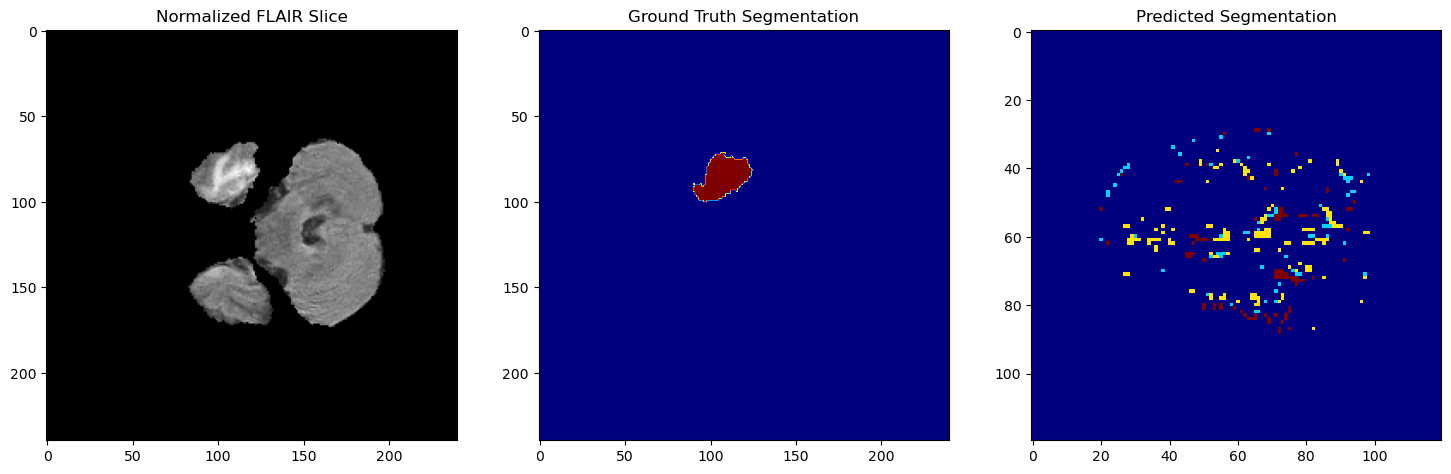

In [7]:
# -----------------------------
# 5. Evaluate the Model
# -----------------------------
# Here, we'll use the same patient data for evaluation for demonstration.
# In practice, use a separate validation set.
preds = model.predict(X_val)

# For visualization, take the class with maximum probability (argmax) for each voxel.
pred_labels = np.argmax(preds[0], axis=-1)

# Visualize one middle slice of the predicted segmentation alongside the ground truth.
slice_idx = pred_labels.shape[2] // 2
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_data_norm[:, :, slice_idx, 0], cmap='gray')
plt.title("Normalized FLAIR Slice")
plt.subplot(1, 3, 2)
plt.imshow(seg_mask[:, :, slice_idx], cmap='jet')
plt.title("Ground Truth Segmentation")
plt.subplot(1, 3, 3)
plt.imshow(pred_labels[:, :, slice_idx], cmap='jet')
plt.title("Predicted Segmentation")
plt.show()